<a href="https://colab.research.google.com/github/Ramjeet-Dixit/IITM-AIML-Rdixit/blob/main/Evidently_gradio_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML Lifecycle with Deployment and Monitoring in Jupyter
## - Run requirements.txt to install required library
## Step 1: Imports

In [ ]:
%%writefile requirements.txt
pandas>=1.3.0
numpy>=1.21.0
scikit-learn>=1.0
gradio>=4.0.0
evidently>=0.4.9

Writing requirements.txt


In [ ]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.5/236.5 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.3/564.3 kB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.8/510.8 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.6/213.6 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.2/452.2 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 70.6 MB/s eta 0:00:00


## Note:

* Ensure `evidently`, `gradio`, and `sklearn` are installed in your environment.
* Run `interface.launch()` in a separate cell if Jupyter Lab blocks output.
* Monitoring report is rendered inline and auto-updates with refreshed test data.

## Step1 : Load the libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from evidently import Report, Dataset, DataDefinition, BinaryClassification
from evidently.presets import ClassificationPreset

## Step2: Load the data and pre-process

In [ ]:
# Load data and preprocess
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

In [ ]:
data.feature_names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

## Step3: Split the data - Data Splitting & Preprocessing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Step4: Build the model

In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

## Step5: Prepare the Dataframes including Predictions

In [ ]:
# Prepare DataFrames including predictions
reference_df = pd.DataFrame(X_train_scaled, columns=X.columns)
reference_df['target'] = y_train
reference_df['prediction'] = model.predict(X_train_scaled)

current_df = pd.DataFrame(X_test_scaled, columns=X.columns)
current_df['target'] = y_test
current_df['prediction'] = model.predict(X_test_scaled)

print("Sklearn Classification Report:")
print(classification_report(current_df['target'], current_df['prediction']))

Sklearn Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.95        43
           1       0.96      0.99      0.97        71

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



In [ ]:
# Create Evidently DataDefinition and Dataset objects
data_def = DataDefinition(
    classification=[BinaryClassification(target="target", prediction_labels="prediction")]
)

reference_dataset = Dataset.from_pandas(reference_df, data_definition=data_def)
current_dataset = Dataset.from_pandas(current_df, data_definition=data_def)

# Create and run Evidently Report, capture results
report = Report(metrics=[ClassificationPreset()])
results = report.run(reference_dataset, current_dataset)

In [ ]:
# # Save and show the report HTML
results.save_html("classification_report.html")
# try:
#     results.show()
# except Exception as e:
#     print(f"Warning: results.show() failed: {e}. Open 'classification_report.html' manually.")


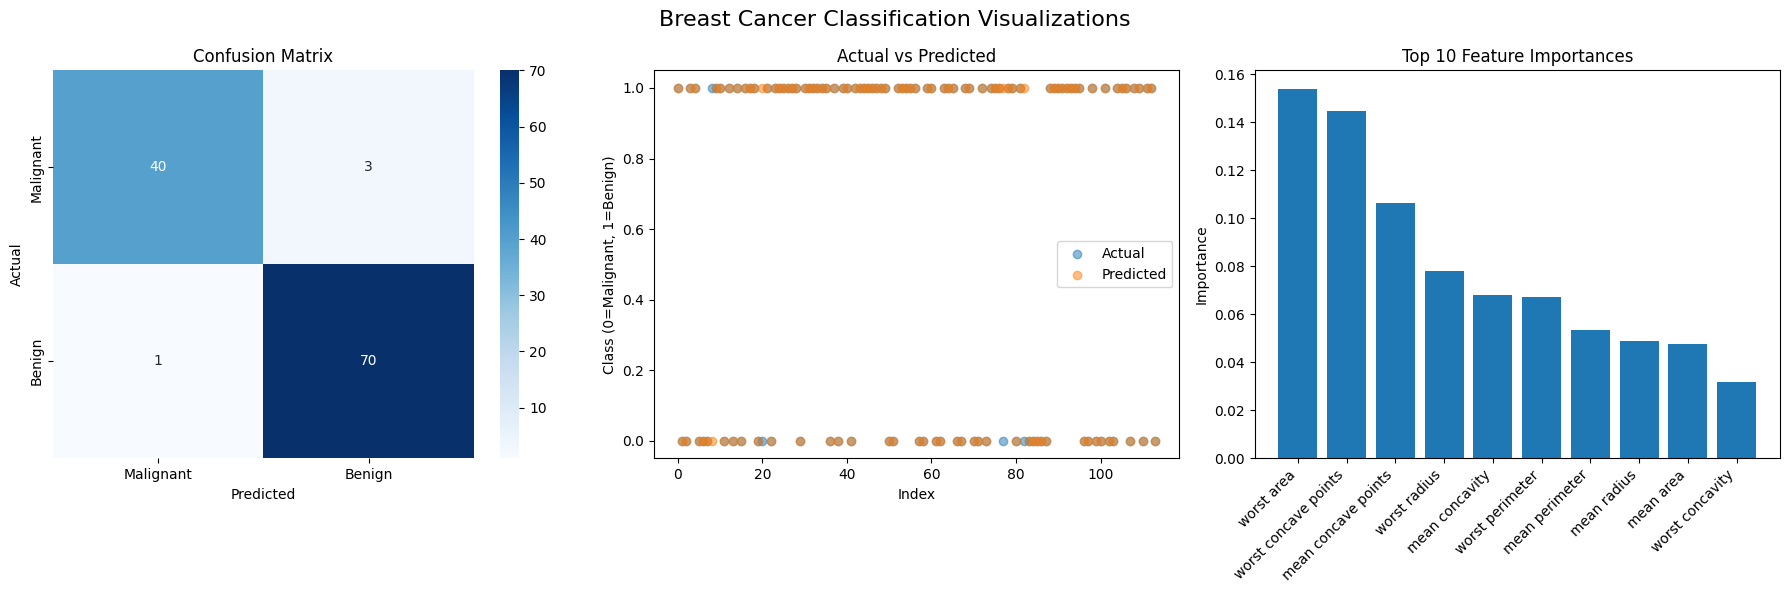

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

In [ ]:

# Visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Breast Cancer Classification Visualizations', fontsize=16)

cm = confusion_matrix(current_df['target'], current_df['prediction'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Malignant', 'Benign'], yticklabels=['Malignant', 'Benign'])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

axes[1].scatter(range(len(current_df['target'])), current_df['target'], label='Actual', alpha=0.5)
axes[1].scatter(range(len(current_df['prediction'])), current_df['prediction'], label='Predicted', alpha=0.5)
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Class (0=Malignant, 1=Benign)')
axes[1].set_title('Actual vs Predicted')
axes[1].legend()

importances = model.feature_importances_
indices = np.argsort(importances)[::-1][:10]
axes[2].bar(range(10), importances[indices])
axes[2].set_xticks(range(10))
axes[2].set_xticklabels([X.columns[i] for i in indices], rotation=45, ha='right')
axes[2].set_title('Top 10 Feature Importances')
axes[2].set_ylabel('Importance')

plt.tight_layout()
plt.savefig('classification_visualizations.png', dpi=300, bbox_inches='tight')
plt.show()

# Gradio interfaces

def show_report():
    with open("classification_report.html", "r") as file:
        return file.read()

report_interface = gr.Interface(fn=show_report, inputs=None, outputs=gr.HTML(), title="Evidently Classification Report")

def predict_gradio(*input_features):
    input_array = np.array(input_features).reshape(1, -1)
    input_scaled = scaler.transform(input_array)
    prediction = model.predict(input_scaled)[0]
    proba = model.predict_proba(input_scaled)[0]
    return {
        "Malignant": float(proba[0]),
        "Benign": float(proba[1]),
    }

inputs = [gr.Number(label=col) for col in X.columns]
prediction_interface = gr.Interface(fn=predict_gradio, inputs=inputs, outputs=gr.Label(num_top_classes=2),
                                    title="Breast Cancer Prediction")

# Launch Gradio prediction interface
prediction_interface.launch(share=False)
# To launch report interface separately, uncomment:
report_interface.launch(share=False)
